In [ ]:
# !pip install numpy pandas scikit-learn tensorflow matplotlib seaborn


# Unveiling Cassava Secrets

This project focuses on leveraging the natural resistance of cassava to drought by studying its DNA and identifying specific sequences called enhancers that play a role in gene regulation. Participants will use a dataset containing 10,000-base pair DNA sequences from the cassava genome, along with associated information such as the chromosome and a target label indicating whether a specific region overlaps with an enhancer. The goal is to build predictive models for enhancer regulatory activity in the cassava genome. The project relies on a combination of genomics, natural language processing, and machine learning techniques, making use of pre-trained NLP models specifically designed to analyze DNA sequences. The competition's evaluation metric is accuracy, and participants are provided with mean-pooled embeddings of a specialized NLP model for their analysis.

## 1. Setting Up environment

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## 2. Loading and Exploring Data

In [39]:
train = pd.read_csv("Train (4).csv")
test_data = pd.read_csv("Test (3).csv")
ss = pd.read_csv("SampleSubmission (4).csv")
variables = pd.read_csv("VariableDefinitions.csv")
test_embeddings = np.load("Test_embeddings.npy")
train_embeddings = np.load("Train_embeddings.npy")
train_data = pd.read_csv("Train (4).csv")
test = pd.read_csv("Test (3).csv")

print(train_embeddings)

[[ 0.34610248 -0.04882112  0.04641166 ... -0.12821618  0.13048221
  -0.04030944]
 [ 0.2685889  -0.11472121 -0.00299174 ... -0.10230525  0.11031647
  -0.11093187]
 [ 0.254905   -0.08910991  0.12141802 ... -0.0814518   0.10907719
  -0.02265033]
 ...
 [ 0.33422753 -0.01488861  0.12528968 ... -0.10773876  0.12452018
  -0.06895437]
 [ 0.34840348 -0.16457166  0.01115987 ... -0.05926268  0.12739813
   0.01560411]
 [ 0.25588453 -0.08713227  0.09167866 ... -0.1202043   0.1287952
  -0.01449904]]


In [40]:
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (13225, 5)
test data shape : (5668, 4)


In [6]:
train.head(10)

,ID,Sequence,Chromosome,Region,Target
0,ID_3uVXob,AAATCTTATTAATATATCTATATATAAATTTTTTAATATATTATAT...,Chromosome06,23466002-23467001,1
1,ID_ViisQV,GCGTCCTCTCACCAGCAGACAAGAATATAAAGATTGAACAACCAAA...,Chromosome16,27234572-27235571,0
2,ID_4HQWG5,TTCACCGAAAGCTTAGAGTAAGGAAAAAAAAAGGAACATTAAAATT...,Chromosome11,24316102-24317101,1
3,ID_E64KC4,AACCCTTATCAGAAAAGTCTTTATGGTATTCAACGGAGGCAAACAA...,Chromosome05,25321688-25322687,0
4,ID_3BPJGs,TTGTGAGGAATGAGATACACATACCCCTTTTAGATTATGAAATGTC...,Chromosome01,9570952-9571951,1
5,ID_3bZ5Up,TCCAACACGATTTTGGTTGGCGATTCATAATTGAATATACAGACTC...,Chromosome06,23942702-23943701,1
6,ID_39PvUU,TGGGGTGCCATAGGAGGTGAGTTTATTAAATTTTTGGATCCCATAT...,Chromosome08,22480390-22481389,0
7,ID_3hpRYG,TTAATGCAAGAAGATGGGACCTGGCTGTCAATAACATTTACCTACG...,Chromosome08,19484727-19485726,1
8,ID_47ZAbD,AGAGCGAAGAGAGGAATGAAAAGTATGCGATGATGGAACCTCTAGC...,Chromosome08,11656193-11657192,0
9,ID_4DCDST,CTCAGGGAAGTTCTCTATATTCTCTCTCTCATTTATTCGGTCTTTT...,Chromosome13,9651315-9652314,0


In [7]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: ID            0
Sequence      0
Chromosome    0
Region        0
Target        0
dtype: int64


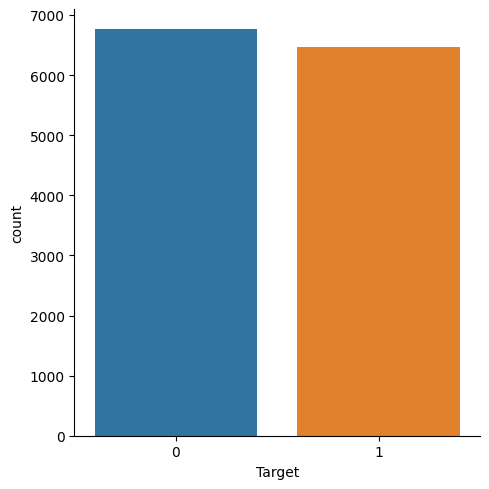

In [7]:
# Explore Target distribution
sns.catplot(x="Target", kind="count", data=train)

In [8]:
ss.head()

,ID,Target
0,ID_4MdeKo,0
1,ID_3oArRM,0
2,ID_3ctixK,0
3,ID_A5ZcYv,0
4,ID_3Kpafn,0


### **Understanding The Test datasets**

In [9]:
test.info()
variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          5668 non-null   object
 1   Sequence    5668 non-null   object
 2   Chromosome  5668 non-null   object
 3   Region      5668 non-null   object
dtypes: object(4)
memory usage: 177.2+ KB


,VARIABLENAME,VARIABLE DESCRIPTION
0,ID,Unique ID for each row.
1,Sequence,1000-base pair (bp) DNA sequence with letters ...
2,Chromosome,Distinct organizational units of the cassava g...
3,Region,The region of the considered Sequence
4,Target,This is what you are predicting: 1 if the midd...


## 3. Preprocessing Data



###  Checking for Base Pair frequencies for sequence

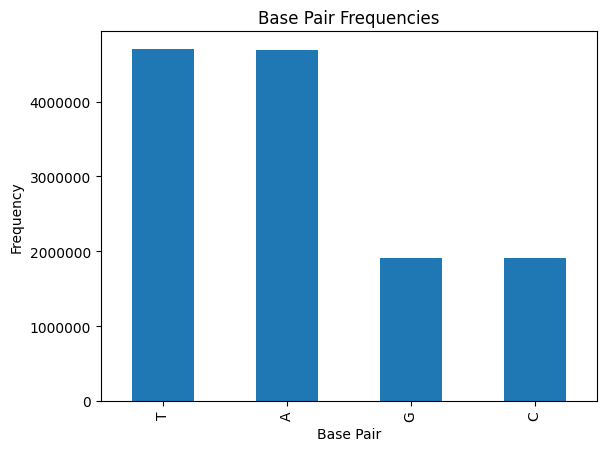

In [41]:
from itertools import chain
from collections import Counter

sequences = train_data['Sequence']
bp_counts  = Counter(chain.from_iterable(sequences))
bp_df = pd.DataFrame.from_dict(bp_counts, orient='index', columns=['Count'])

# Plot base pair frequencies
ax = bp_df.sort_values('Count', ascending=False).plot(kind='bar', legend=None)
ax.set_title('Base Pair Frequencies')
ax.set_xlabel('Base Pair')
ax.set_ylabel('Frequency')

# Format y-axis labels as decimal notation
ax.yaxis.set_major_formatter('{x:.0f}')
plt.show()

## Preprocess DNA sequences for training and test data

basic one-hot encoding for the DNA sequences. Each nucleotide (A, G, C, T) will be represented by a binary vector.

In [42]:
# Function for one-hot encoding DNA sequences
def one_hot_encoding(sequence):
    mapping = {'A': [1, 0, 0, 0], 'G': [0, 1, 0, 0], 'C': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    return np.array([mapping[base] for base in sequence])

# Applying one-hot encoding
train_data['Sequence_encoded'] = train_data['Sequence'].apply(one_hot_encoding)

test_data['Sequence_encoded'] = test_data['Sequence'].apply(one_hot_encoding)

train_data.head()


,ID,Sequence,Chromosome,Region,Target,Sequence_encoded
0,ID_3uVXob,AAATCTTATTAATATATCTATATATAAATTTTTTAATATATTATAT...,Chromosome06,23466002-23467001,1,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0,..."
1,ID_ViisQV,GCGTCCTCTCACCAGCAGACAAGAATATAAAGATTGAACAACCAAA...,Chromosome16,27234572-27235571,0,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,..."
2,ID_4HQWG5,TTCACCGAAAGCTTAGAGTAAGGAAAAAAAAAGGAACATTAAAATT...,Chromosome11,24316102-24317101,1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [1,..."
3,ID_E64KC4,AACCCTTATCAGAAAAGTCTTTATGGTATTCAACGGAGGCAAACAA...,Chromosome05,25321688-25322687,0,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0,..."
4,ID_3BPJGs,TTGTGAGGAATGAGATACACATACCCCTTTTAGATTATGAAATGTC...,Chromosome01,9570952-9571951,1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0,..."


### **Combining Features**
Combining the DNA sequence data with the mean-pooled embeddings to create a unified feature set.

In [43]:
# Reshaping one-hot encoded sequences for
# training data
sequences_train = np.array(train_data['Sequence_encoded'].values.tolist())
sequences_train = sequences_train.reshape(sequences_train.shape[0], -1)
#test data
sequences_test = np.array(test_data['Sequence_encoded'].values.tolist())
sequences_test = sequences_test.reshape(sequences_test.shape[0], -1)

# Combine features
X_train = np.concatenate([sequences_train, train_embeddings], axis=1)

X_test = np.concatenate([sequences_test, test_embeddings], axis=1)

X_train


array([[ 1.        ,  0.        ,  0.        , ..., -0.12821618,
         0.13048221, -0.04030944],
       [ 0.        ,  1.        ,  0.        , ..., -0.10230525,
         0.11031647, -0.11093187],
       [ 0.        ,  0.        ,  0.        , ..., -0.0814518 ,
         0.10907719, -0.02265033],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.10773876,
         0.12452018, -0.06895437],
       [ 0.        ,  0.        ,  0.        , ..., -0.05926268,
         0.12739813,  0.01560411],
       [ 0.        ,  0.        ,  0.        , ..., -0.1202043 ,
         0.12879521, -0.01449904]])

In [ ]:
# # Combine features for training data
# X_train = np.concatenate([train_data['Sequence_encoded'].values.tolist(), train_embeddings], axis=1)

# # Combine features for test data
# X_test = np.concatenate([test_data['Sequence_encoded'].values.tolist(), test_embeddings], axis=1)


In [44]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, train_data['Target'].values, test_size=0.2, random_state=42)


## 4. Model Selection and Training

### Choosing a model
Given the nature of DNA sequences, we decided to use a basic feedforward neural network

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# simple feedforward neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
custom_optimizer = Adam(learning_rate=0.00099)
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               1408256   
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1441281 (5.50 MB)
Trainable params: 1441281 (5.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
import tensorflow as tf

# Converting NumPy arrays to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split)).batch(190)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(10)

# Training the model using TensorFlow Datasets
history = model.fit(train_dataset, epochs=25, validation_data=val_dataset)


Epoch 1/25
56/56 [==============================] - 15s 134ms/step - loss: 0.6573 - accuracy: 0.6113 - val_loss: 0.5740 - val_accuracy: 0.6900
Epoch 2/25
56/56 [==============================] - 9s 105ms/step - loss: 0.5120 - accuracy: 0.7405 - val_loss: 0.5880 - val_accuracy: 0.6911
Epoch 3/25
56/56 [==============================] - 10s 109ms/step - loss: 0.4646 - accuracy: 0.7747 - val_loss: 0.6349 - val_accuracy: 0.6824
Epoch 4/25
56/56 [==============================] - 10s 109ms/step - loss: 0.4404 - accuracy: 0.7923 - val_loss: 0.7978 - val_accuracy: 0.6427
Epoch 5/25
56/56 [==============================] - 9s 100ms/step - loss: 0.4440 - accuracy: 0.7833 - val_loss: 0.6524 - val_accuracy: 0.6737
Epoch 6/25
56/56 [==============================] - 12s 135ms/step - loss: 0.4035 - accuracy: 0.8137 - val_loss: 0.6960 - val_accuracy: 0.6771
Epoch 7/25
56/56 [==============================] - 10s 113ms/step - loss: 0.3864 - accuracy: 0.8227 - val_loss: 0.7230 - val_accuracy: 0.6715
E

In [ ]:
#Train the model
# history = model.fit(X_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(X_val, y_val))
#train_dataset
#val_dataset

265/265 [==============================] - 1s 5ms/step - loss: 0.6808 - accuracy: 0.6756
Validation Loss: 0.680750846862793, Validation Accuracy: 0.6756143569946289


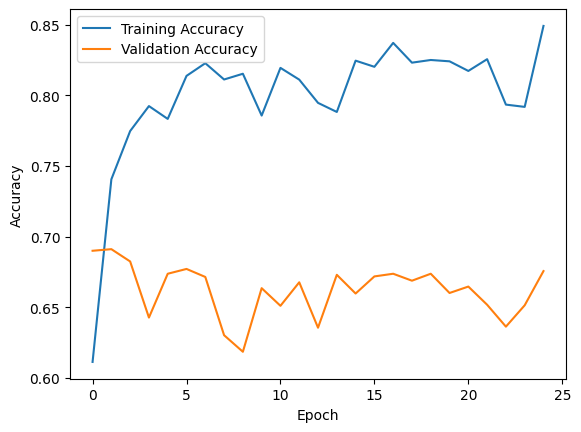

In [48]:
#Evaluating Performance
import matplotlib.pyplot as plt

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 5. Model Tuning and Optimization

### Tunning Hyperparameters
Playing with hyperparameters to optimize the model. We will use the following parameters: learning rate, batch size, the number of layers, and the number of neurons in each layer.

In [17]:
# from tensorflow.keras.optimizers import Adam

# # Example of hyperparameter tuning
# model = Sequential([
#     Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(128, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# # Adjust the learning rate
# custom_optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


Addressing Overfitting bg dropout and regularization

In [18]:
# from tensorflow.keras.layers import Dropout

# model = Sequential([
#     Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])


Re-evaluating the model performance

In [49]:
# Compile the model with the same configuration used during training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate performance on the validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


265/265 [==============================] - 6s 4ms/step - loss: 0.6808 - accuracy: 0.6756
Validation Loss: 0.680750846862793, Validation Accuracy: 0.6756143569946289


## 6. Generating Predictions for the test data

Preprocessing the test data

In [30]:
# # Preprocessing the test data with the same steps used for training data

# test_sequences = np.array(test_data['Sequence_encoded'].values.tolist())
# test_sequences = test_sequences.reshape(test_sequences.shape[0], -1)

# X_test = np.concatenate([test_sequences, test_embeddings], axis=1)


Making Predictions on the test data

In [31]:
# # Make predictions on the test set
# test_predictions = model.predict(X_test)

178/178 [==============================] - 17s 19ms/step


## TRYING DIFFERENT HYPERPARAMETERS AND MODELS

LSTM LAYERS AND NEURONS

In [32]:
# from tensorflow.keras.layers import LSTM

# # Assuming each sequence has length 1000
# sequence_length = 1000

# # Reshape the sequences for LSTM input
# sequences_train_reshaped = sequences_train.reshape((sequences_train.shape[0], sequence_length, -1))
# sequences_test_reshaped = sequences_test.reshape((sequences_test.shape[0], sequence_length, -1))

# # Define the model
# model = Sequential([
#     LSTM(128, activation='relu', input_shape=(sequence_length, sequences_train_reshaped.shape[2])),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [33]:
# #Learning Rate Annealing
# from tensorflow.keras.optimizers import Adam

# custom_optimizer = Adam(learning_rate=0.00001)
# model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [34]:
# from tensorflow.keras.layers import Dropout

# model = Sequential([
#     Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])


In [50]:
from sklearn.metrics import classification_report

# Get predictions on validation set
val_predictions = model.predict(val_dataset)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
val_binary_predictions = (val_predictions > 0.5).astype(int)

# Evaluate additional metrics
print(classification_report(y_val, val_binary_predictions))


265/265 [==============================] - 6s 5ms/step
              precision    recall  f1-score   support

           0       0.73      0.59      0.65      1373
           1       0.63      0.77      0.70      1272

    accuracy                           0.68      2645
   macro avg       0.68      0.68      0.67      2645
weighted avg       0.69      0.68      0.67      2645



## 7. Creating Submission File

In [32]:
#Formating Predictions
# Converting predictions to binary (0 or 1)
threshold = 0.5
binary_predictions = (test_predictions > threshold).astype(int)


In [33]:
#Generating submission file
# Creating a DataFrame for submission
submission_df = pd.DataFrame({'ID': test_data['ID'], 'Target': binary_predictions.flatten()})

submission_df.to_csv('submission.csv', index=False)


## Connecting To Streamlit

In [51]:
model.save('trained_model1.keras')

## -- Using Instadeep AGRONT Model

Combining Features with Instadeep

In [ ]:
train_agront_embeddings = np.load("/content/drive/MyDrive/Cassava Project-20231209T132333Z-001/Cassava Project/Train_embeddings.npy")

test_agront_embeddings = np.load("/content/drive/MyDrive/Cassava Project-20231209T132333Z-001/Cassava Project/Test_embeddings.npy")

X_train_combined = np.concatenate([sequences_train, train_agront_embeddings], axis=1)

# Combining features for test data
X_test_combined = np.concatenate([sequences_test, test_agront_embeddings], axis=1)


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.image import resize

#
# train_agront_embeddings_resized = train_agront_embeddings.reshape(-1, 30, 50, 1)
# test_agront_embeddings_resized = test_agront_embeddings.reshape(-1, 30, 50, 1)

# # Resizing to meet the minimum size requirement
# target_size = (32, 32)
# train_agront_embeddings_resized = np.array([img_to_array(resize(array_to_img(x), target_size)) for x in train_agront_embeddings_resized])
# test_agront_embeddings_resized = np.array([img_to_array(resize(array_to_img(x), target_size)) for x in test_agront_embeddings_resized])

# # Load pre-trained AgroNT model
# agront_model = DenseNet121(weights=None, include_top=False, input_shape=(32, 32, 1), pooling='avg')


### Fine-tuning a pre-trained model on AgroNT embeddings

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model

# Assuming mean-pooled embeddings have a shape of (1500,)
train_agront_embeddings_reshaped = train_agront_embeddings.reshape(-1, 30, 50, 1)
test_agront_embeddings_reshaped = test_agront_embeddings.reshape(-1, 30, 50, 1)

# # Load pre-trained AgroNT model
# agront_model = DenseNet121(weights=None, include_top=False, input_shape=(30, 50, 1), pooling='avg')


# # Add additional layers for your specific task
# x = agront_model.output
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# output_layer = layers.Dense(1, activation='sigmoid')(x)

# # Create the combined model
# combined_model = Model(inputs=agront_model.input, outputs=output_layer)

# # Compile the combined model
# combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
